In [23]:
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

import keras
from keras.models import Sequential
from keras.layers import Masking, LSTM, TimeDistributed, Dense
from keras.callbacks import EarlyStopping

In [2]:
input_data = pd.read_csv('raw_data/raw_remnant_input.csv')
modeling_data = pd.read_csv('raw_data/raw_remnant_target.csv')

In [3]:
categorical_features = ['directory_1', 
                         'directory_2', 
                         'directory_3', 
                         'sequence_id', 
                         'is_skill_builder', 
                         'has_due_date', 
                         'assignment_completed']

continuous_features = ['time_since_last_assignment_start', 
                        'session_count_raw',
                        'session_count_normalized', 
                        'session_count_class_percentile',
                        'day_count_raw', 
                        'day_count_normalized', 
                        'day_count_class_percentile',
                        'completed_problem_count_raw', 
                        'completed_problem_count_normalized',
                        'completed_problem_count_class_percentile',
                        'median_ln_problem_time_on_task_raw',
                        'median_ln_problem_time_on_task_normalized',
                        'median_ln_problem_time_on_task_class_percentile',
                        'median_ln_problem_first_response_time_raw',
                        'median_ln_problem_first_response_time_normalized',
                        'median_ln_problem_first_response_time_class_percentile',
                        'average_problem_attempt_count',
                        'average_problem_attempt_count_normalized',
                        'average_problem_attempt_count_class_percentile',
                        'average_problem_answer_first',
                        'average_problem_answer_first_normalized',
                        'average_problem_answer_first_class_percentile',
                        'average_problem_correctness', 
                        'average_problem_correctness_normalized',
                        'average_problem_correctness_class_percentile',
                        'average_problem_hint_count', 
                        'average_problem_hint_count_normalized',
                        'average_problem_hint_count_class_percentile',
                        'average_problem_answer_given',
                        'average_problem_answer_given_normalized',
                        'average_problem_answer_given_class_percentile',
                        'time_since_last_assignment_start_cluster']

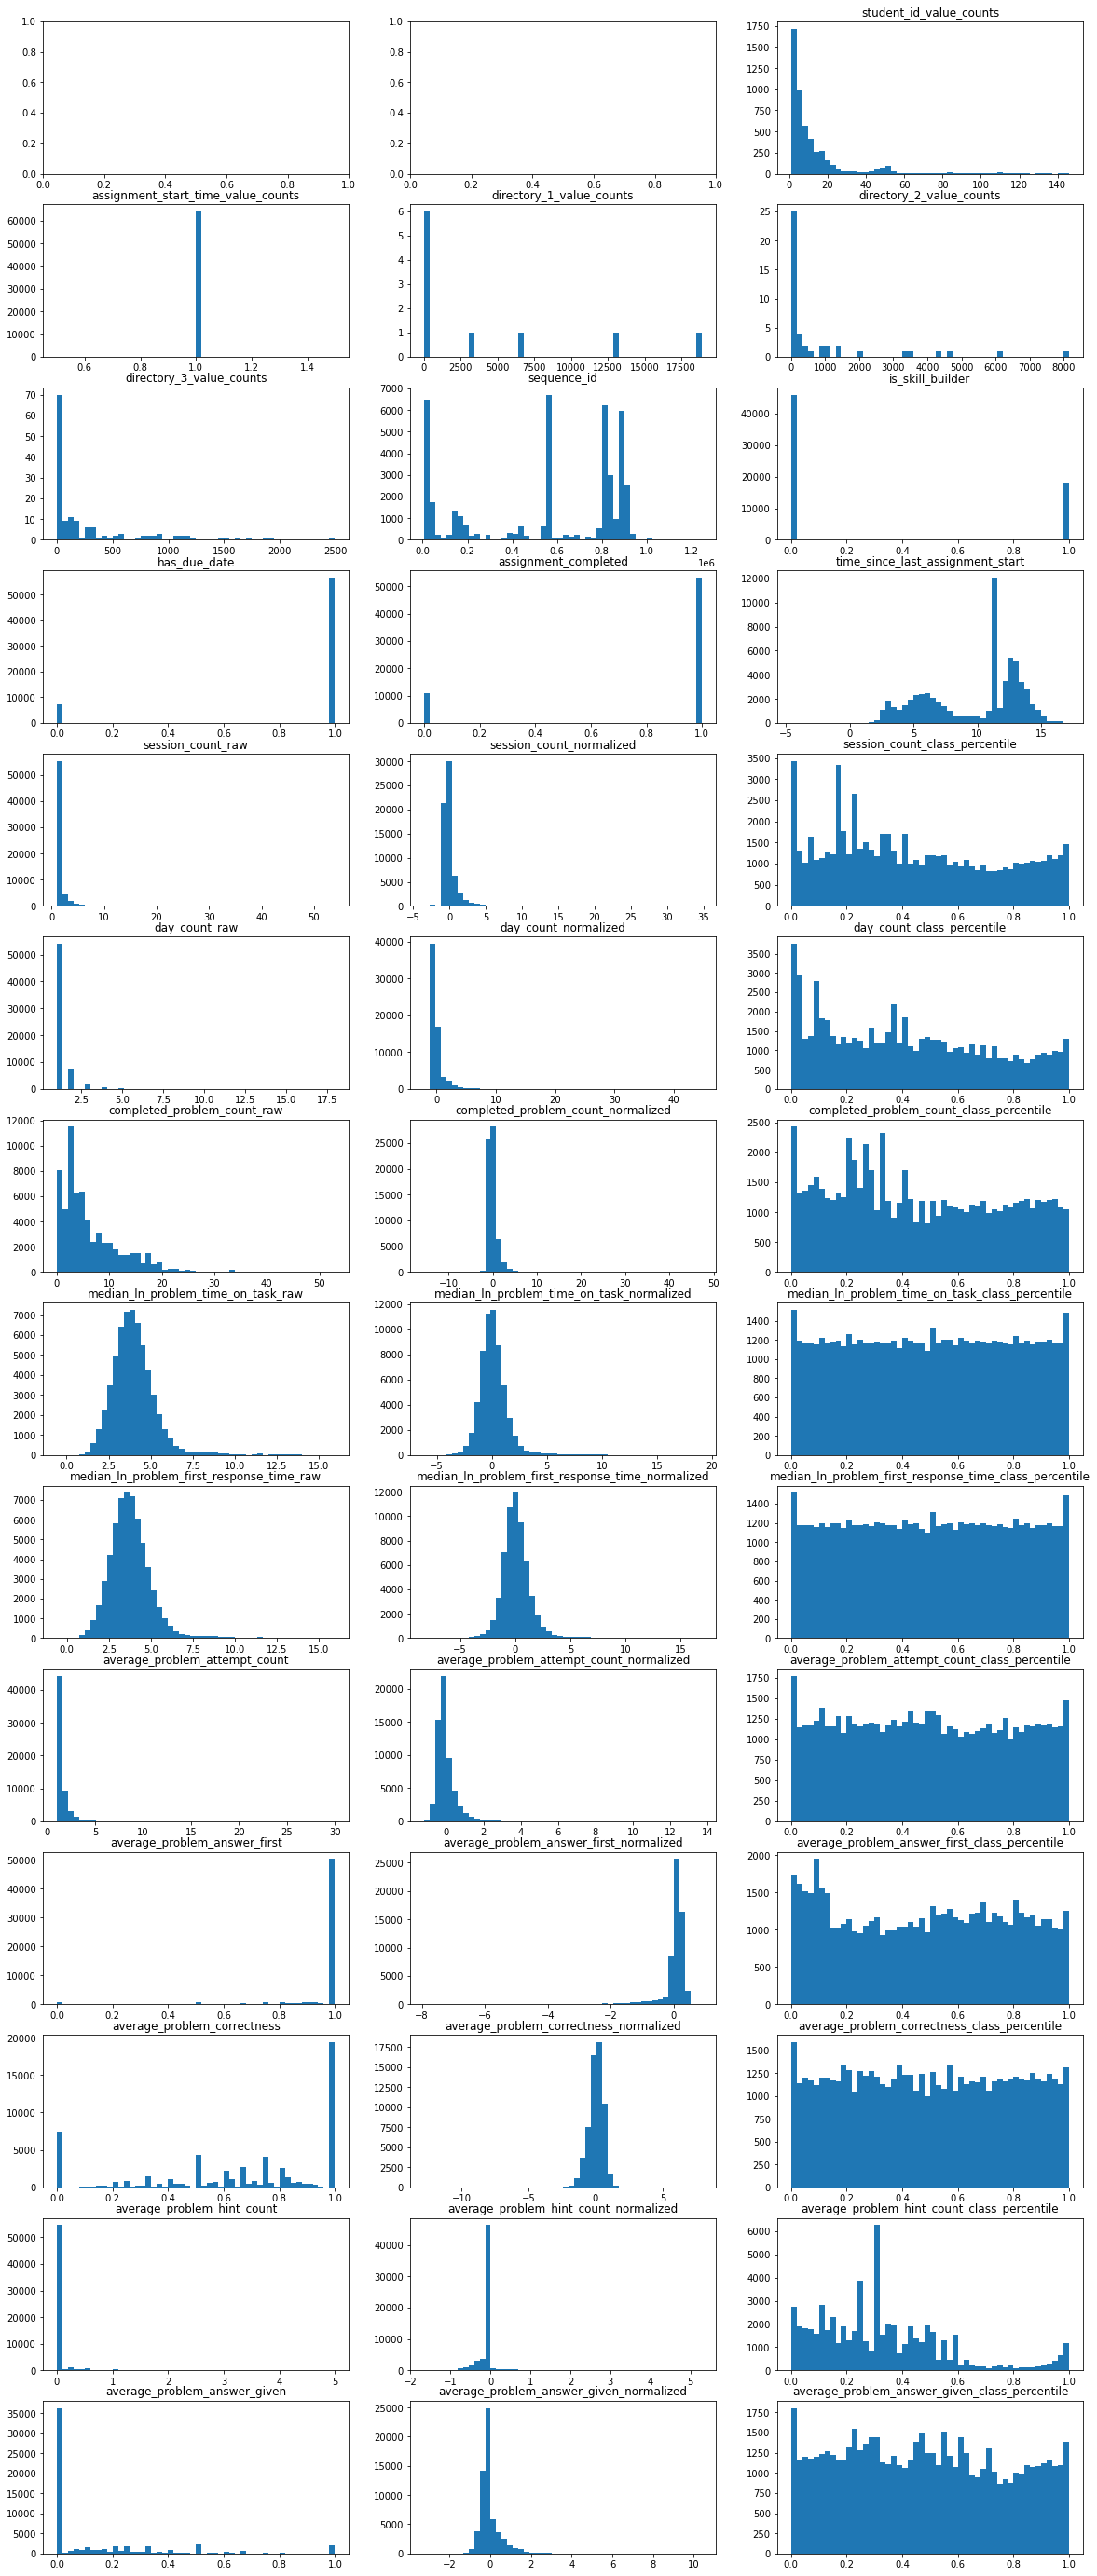

In [4]:
# Look at the distributions of all the raw inputs, or the frequency of values in the raw inputs

PLOT_ROWS = 14
PLOT_COLS = 3

fig, axs = plt.subplots(PLOT_ROWS, PLOT_COLS, figsize=(20,50))

offset = PLOT_ROWS * PLOT_COLS - len(input_data.columns)

for i in range(len(input_data.columns)):
    r = int((i + offset) / PLOT_COLS)
    c = (i + offset) % PLOT_COLS
    col = input_data.columns[i]
    axs[r, c].hist(input_data[col].value_counts() if i < 5 else input_data[col], 50)
    axs[r, c].set_title(col + '_value_counts' if i < 5 else col)
fig.savefig('first_look.png', dpi=200)

In [5]:
# Create additional features

# An explicit feature for which cluster the time_since_last_assignment_start falls into
clusters = 4
times = input_data['time_since_last_assignment_start'].values.reshape(-1, 1)
input_data['time_since_last_assignment_start_cluster'] = GaussianMixture(n_components=clusters).fit(times).predict(times)
categorical_features.append('time_since_last_assignment_start_cluster')

# A feature for whether or not there is a folder path
input_data['custom_assignment'] = input_data['directory_1'].isna().astype(int)
categorical_features.append('custom_assignment')

# A feature for whether or not there is any problem level data
input_data['no_problem_statsistics'] = input_data['median_ln_problem_time_on_task_raw'].isna().astype(int)
categorical_features.append('no_problem_statsistics')

# Replace NaN categorical features with -1
input_data[categorical_features] = input_data[categorical_features].fillna(-1)

In [6]:
# Add the previous assignments to the training data
modeling_data['previous_assignments'] = None

for i, row in modeling_data.iterrows():
    row_input = input_data[(input_data['assignment_start_time'] < row['assignment_start_time']) & (input_data['student_id'] == row['student_id'])].sort_values('assignment_start_time')
    if len(row_input) > 0:
        modeling_data.at[i, 'previous_assignments'] = row_input

modeling_data = modeling_data[~modeling_data['previous_assignments'].isna()]

In [15]:
#auc maybe kappa and rmse, r2, naglekerke r2 for categorical

def process_input(df_list, one_hot_encoder=None, normalizer=None, max_sequence_length=20):
    
    if one_hot_encoder is None:
        categorical_data = np.concatenate([df[categorical_features].values for df in df_list])
        continuous_data = np.concatenate([df[continuous_features].values for df in df_list])
        one_hot_encoder = OneHotEncoder(handle_unknown='ignore').fit(categorical_data)
        normalizer = StandardScaler().fit(continuous_data)
    
    processed_input = []
    for df in df_list:
        categorical_data = one_hot_encoder.transform(df[categorical_features]).toarray()
        continuous_data = np.nan_to_num(normalizer.transform(df[continuous_features]))
        combined_data = np.concatenate([categorical_data, continuous_data], axis=1)
        #combined_data = categorical_data
        #combined_data = continuous_data
        if combined_data.shape[0] >= max_sequence_length:
            resized_data = combined_data[-max_sequence_length:,:]
        else:
            resized_data = np.zeros((max_sequence_length, combined_data.shape[1]))
            resized_data[-combined_data.shape[0]:,:] = combined_data
        processed_input.append(resized_data)
    
    return np.stack(processed_input), one_hot_encoder, normalizer

In [ ]:
# Split the data into training and testing sets
# Normalize and one hot encode the data based on the input data

N_SPLITS = 5
LAYERS = [1, 2, 3, 4]
NODES = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

layers = []
nodes = []
auc = []

for lay in LAYERS:
    for nod in NODES:
        for train_index, test_index in GroupKFold(N_SPLITS).split(modeling_data, groups=modeling_data['student_id']):
            
            print(f'{datetime.now()}: layers: {lay}, nodes: {nod}')
            
            training_input, input_one_hot_encoder, input_normalizer = process_input(modeling_data.iloc[train_index]['previous_assignments'].tolist())
            #training_target = modeling_data.iloc[train_index][['assignment_completed', 'problems_completed']].values
            training_target = modeling_data.iloc[train_index][['assignment_completed']].values
            testing_input, _, _ = process_input(modeling_data.iloc[test_index]['previous_assignments'].tolist(), input_one_hot_encoder, input_normalizer)
            #testing_target = modeling_data.iloc[test_index][['assignment_completed', 'problems_completed']].values
            testing_target = modeling_data.iloc[test_index][['assignment_completed']].values

            keras.backend.clear_session()
            lstm = Sequential()
            lstm.add(Masking(mask_value=0.0, input_shape=(training_input[0].shape)))
            for i in range(lay-1):
                lstm.add(LSTM(nod, activation='tanh', return_sequences=True))
            lstm.add(LSTM(nod, activation='tanh', return_sequences=False))
            lstm.add(Dense(training_target.shape[1], activation='sigmoid'))
            lstm.compile(optimizer='adam', loss='binary_crossentropy')
            es = [EarlyStopping(monitor='val_loss', patience=5, min_delta=0, restore_best_weights=True)]
            lstm.fit(training_input, training_target, epochs=1000, validation_split=0.2, callbacks=es, verbose=False)
            testing_output = lstm.predict(testing_input)
            layers.append(lay)
            nodes.append(nod)
            auc.append(roc_auc_score(testing_target, testing_output))
                  
            print(f'auc: {auc[-1]}')

print(layers[np.argmax(auc)], nodes[np.argmax(auc)], np.amax(auc))

2021-06-25 14:35:58.083703: layers: 1, nodes: 1


In [ ]:
# Just categorical: 0.7312149998029336
# Just continuous: 0.6897450090394278
# Together: 0.756996812705715